In [54]:
#pip install numpy
#pip install SimpleITK

In [3]:
import SimpleITK as sitk
import matplotlib.pylab as plt
import numpy as np
from PIL import Image
import cv2
from skimage import color
from skimage import io
import lodgepole as lit
from image_tools.sizes import resize_and_crop
import matplotlib.image as mpimg
import pandas as pd 
from sklearn.model_selection import train_test_split
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border, mark_boundaries
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
from glob import glob
from skimage.io import imread

In [48]:
fleischner_data = pd.read_csv("d:/Licenta/CSV/Train/trainFleischner.csv", skiprows=[0], header = None)
fleischner_data = fleischner_data.values.tolist()
train_label = pd.read_csv("d:/Licenta/CSV/Train/trainNodules_gt.csv", skiprows=[0], header = None)
train_label = train_label.drop(2, 1)
train_label = train_label.values.tolist()
#ID | No. Rad | Finding ID | x y z | Agreement | Nodule | Volume | Texture
for el in train_label:
    el[1] = len(el[1].split(','))
#print(len(train_label[0][1].split(',')))
#print(train_label)

D:\TEMP/ipykernel_22864/1510693624.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train_label = train_label.drop(2, 1)


In [124]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(10, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < -200
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

In [169]:
def savePictures(path, index_list , image_width, image_height):
    for index in index_list:
        current_number = ""
        if index < 10:
            curent_number = "000" + str(index)
        elif index < 100:
            curent_number = "00" + str(index)
        elif index < 1000:
            curent_number = "0" + str(index)
        else:
            curent_number = str(index)
        current_path = path + "LNDb-" + curent_number 
        image_array = sitk.GetArrayFromImage(sitk.ReadImage(current_path + ".mhd", sitk.sitkFloat32))
        image_array = resizeImages(image_array, image_width, image_height)
        #image_array = normalize_array(image_array)
        segmented_ct_scan = segment_lung_from_ct_scan(image_array)
        segmented_ct_scan[segmented_ct_scan >= 500] = 1
        segmented_ct_scan[segmented_ct_scan == 0] = -1000
        np.save(current_path + ".jpg", segmented_ct_scan)
        

In [126]:
def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(10, 40))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 

In [117]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

In [146]:
'''img = sitk.GetArrayFromImage(sitk.ReadImage("d:/Licenta/Train/LNDb-0010.mhd", sitk.sitkFloat32))
im = get_segmented_lungs(img[180], True)
segmented_ct_scan = segment_lung_from_ct_scan(img)
segmented_ct_scan[segmented_ct_scan >= 500] = 1
segmented_ct_scan[segmented_ct_scan == 0] = -1000
plot_ct_scan(segmented_ct_scan)'''

'img = sitk.GetArrayFromImage(sitk.ReadImage("d:/Licenta/Train/LNDb-0010.mhd", sitk.sitkFloat32))\nim = get_segmented_lungs(img[180], True)\nsegmented_ct_scan = segment_lung_from_ct_scan(img)\nsegmented_ct_scan[segmented_ct_scan >= 500] = 1\nsegmented_ct_scan[segmented_ct_scan == 0] = -1000\nplot_ct_scan(segmented_ct_scan)'

In [81]:
def show_slice_window(slice, level, window):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    maxi = level + window/2
    mini = level - window/2
    slice = slice.clip(mini,maxi)
    plt.imshow(slice.T)
    plt.gray()
    plt.show()

In [50]:
def getLabel(id, train_labels):
    labels = []
    for el in train_labels:
        if el[0] == id:
            labels.append(el)
    return labels

In [31]:
def getIndexLists(path_to_train, path_to_test):
    train_index = pd.read_csv(path_to_train + "trainCTs.csv", skiprows=[0], usecols = [0], header = None) 
    test_index = pd.read_csv(path_to_test + "testCTs.csv", skiprows=[0], usecols = [0], header = None) 
    train_index = train_index[0].tolist()
    test_index = test_index[0].tolist()
    return train_index, test_index

In [38]:
def normalize_array(image_array):
    normalized_array = []
    for index in range(len(image_array)):
        normalized_array.append(image_array[index] / 255)
    return normalized_array

In [148]:
def resizeImages(array_images,width, height):
    img_stack_sm = np.zeros((len(array_images), height, width))
    for idx in range(len(array_images)):
        img = array_images[idx, :, :]
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_sm = cv2.resize(img, (width, height), interpolation=cv2.INTER_LANCZOS4)
        img_stack_sm[idx, :, :] = img_sm
    return img_stack_sm

In [46]:
def getPictures(path, label_list, index_list , image_width, image_height):
    pictures = []
    labels = []
    for index in index_list:
        current_label = []
        current_number = ""
        if index < 10:
            curent_number = "000" + str(index)
        elif index < 100:
            curent_number = "00" + str(index)
        elif index < 1000:
            curent_number = "0" + str(index)
        else:
            curent_number = str(index)
        current_path = path + "LNDb-" + curent_number + ".jpg.npy"
        current_label = getLabel(index, label_list)
        labels.append(current_label)
        image_array = np.asarray(np.load(current_path).astype(np.float32))
        image_array = normalize_array(image_array)
        pictures.append(image_array)
    return pictures, labels

In [32]:
train_path = "d:/Licenta/CSV/Train/"
test_path = "d:/Licenta/CSV/Test/"
train_index, test_index = getIndexLists(train_path, test_path)

In [173]:
savePictures("d:/Licenta/Train/", train_index, 128, 128)

In [51]:
images, labels = getPictures("d:/Licenta/Train/", train_label, train_index, 128, 128)

In [ ]:
#test_images = getPictures("d:/Licenta/Test/", test_index, 128, 128)

In [52]:
print(len(images))
print(len(labels))
#print(len(test_images))

236
236


In [53]:
X_train, X_test, Y_train, Y_test = [], [], [], []
X_train, X_test, Y_train, Y_test = train_test_split(images,labels,test_size=0.2)

In [55]:
print(X_train[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


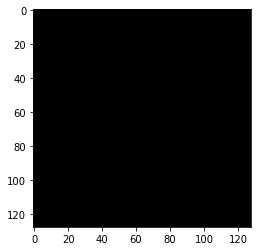

In [62]:
plt.imshow(X_train[0])
plt.show()